# import & read

In [1]:
import pandas as pd
import itertools
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
data=pd.read_csv('continuous_flights_data.csv')

# find flight with much data and constant airport

In [ ]:
def check_soundness(data):
    flights = data['FLIGHT_ID'].unique()
    
    for flight in flights:
        _data = data.loc[data['FLIGHT_ID'] == flight]
        agg_airport = _data.groupby("DESTINATION_AIRPORT").size().reset_index().rename({0:'num'},axis=1)
        agg_date = _data.groupby("Date").size().reset_index().rename({0:'num'},axis=1)
        
        print(agg_airport)
        print(agg_date)

In [84]:
n=[]
for i in data['FLIGHT_ID'].unique():
    if len(n)>=5:
        break
    else:
        datai=data.loc[data['FLIGHT_ID']==i]
        if (len(datai)==365) & (len(datai['DESTINATION_AIRPORT_IATA'].unique())==1) & (len(datai['ORIGIN_AIRPORT_IATA'].unique())==1):
            print(i)
            n.append(i)
    

AA102
AA1042
AA123
AA1406
AA1486


# def and fit the arima model

In [73]:
class pipline:
    def __init__(self,flights,is_iqr,is_boxcox,train_ratio=0.8):
        self.flights = flights
        self.is_iqr = is_iqr,
        self.is_boxcox = is_boxcox 
        self.train_ratio = train_ratio

    def IQR(self,y):
        Q3 = y.quantile(0.75)
        Q1 = y.quantile(0.25)
        IQR = Q3-Q1
        lower_bound = Q1 - IQR*1.5
        upper_bound = Q3 + IQR*1.5

        y[(y > upper_bound).values | (y<lower_bound).values] = np.nan
        y = y.interpolate(method='linear') 
        return y
    
    def box_cox(self,y):
        y_min = np.min(y)-0.1
        y_box, lbd = boxcox(y.values.ravel()-y_min.ravel())  
        self.lbd = lbd
        self.y_min = y_min
        return y_box
    
    def fit(self,start_p,start_q,max_p,max_q):
        y_raw = self.flights.iloc[:int(np.floor(self.flights.shape[0]*self.train_ratio)),:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')
        y_test = self.flights.iloc[int(np.floor(self.flights.shape[0]*self.train_ratio)):,:].loc[:,['ARRIVAL_DELAY','SD']].set_index('SD').interpolate(method='linear')

        if self.is_iqr:
            y_iqr = self.IQR(y_raw)
        else:
            y_iqr = y_raw

        if self.is_boxcox:
            y_box = self.box_cox(y_iqr)
        else:
            y_box = y_iqr

        y_box = pd.Series(y_box).dropna()

        model = pm.auto_arima(y_box, seasonal=False, trace=False,start_p=start_p,start_q=start_q,max_p=max_p,max_q=max_q)
        self.model = model

        y_pred = []
        for i in range(len(y_test)):
            forecast = model.predict_in_sample(X=y_box, start=len(y_box)-len(y_test)+i, end=len(y_box)-len(y_test)+i)
            y_pred.append(forecast.iloc[0])

        y_pred = np.array(y_pred)

        if self.is_boxcox:
            # 对预测值进行box-cox逆变换
            y_pred = inv_boxcox(y_pred, self.lbd) + self.y_min.ravel()

        self.y_test = y_test
        self.y_pred = y_pred

    def metrics(self):
        rmse = np.sqrt(mean_squared_error(self.y_test, self.y_pred))
        print(f"RMSE: {rmse:.3f}")

        # 计算MAE
        mae = mean_absolute_error(self.y_test, self.y_pred)
        print(f"MAE: {mae:.3f}")

        # 计算MAPE
        mape = mean_absolute_percentage_error(self.y_test, self.y_pred)
        print(f"MAPE: {mape:.3%}")

    def summary(self):
        print(self.model.summary())

    def plot(self):
        # 绘制实际值和预测值
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.values, label='Actual')
        plt.plot(self.y_pred, label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Actual vs. Predicted Values')
        plt.legend()
        plt.show()


In [ ]:
'''AA102
AA1042
AA123
AA1406
AA1486'''

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  290
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -10497.445
Date:                Wed, 08 May 2024   AIC                          20998.890
Time:                        16:12:50   BIC                          21006.230
Sample:                             0   HQIC                         21001.831
                                - 290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1775      0.038      4.699      0.000       0.103       0.252
sigma2       1.62e+30   1.99e-32   8.15e+61      0.000    1.62e+30    1.62e+30
Ljung-Box (L1) (Q):                   1.08   Jarque-

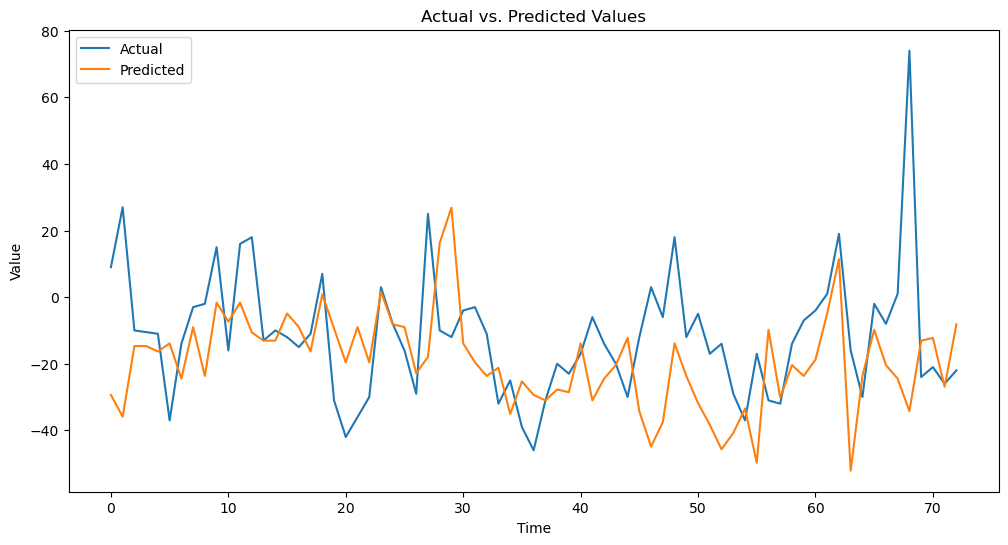

RMSE: 23.507
MAE: 16.699
MAPE: 197.599%


In [83]:
P = pipline(data.loc[data['FLIGHT_ID'] == 'AA102'],True,True)
P.fit(1,1,10,10)
P.summary()
P.plot()
P.metrics()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -841.524
Date:                Wed, 08 May 2024   AIC                           1691.048
Time:                        16:12:38   BIC                           1705.755
Sample:                             0   HQIC                          1696.939
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.7073      0.907      6.295      0.000       3.930       7.484
ar.L1          0.3505      0.053      6.622      0.000       0.247       0.454
ar.L2          0.2389      0.055      4.372      0.0

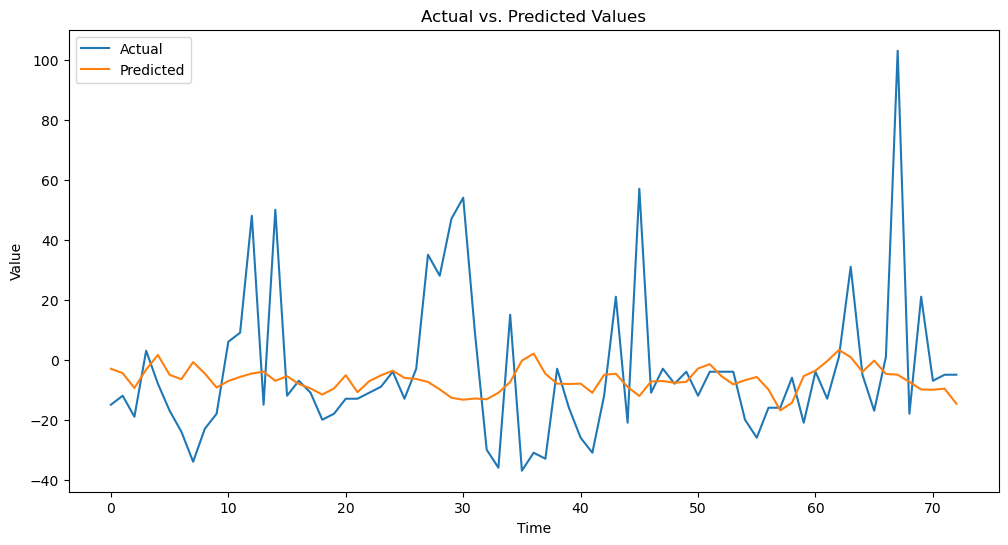

RMSE: 25.504
MAE: 16.741
MAPE: 93.090%


In [82]:
P = pipline(data.loc[data['FLIGHT_ID'] == 'AA1042'],True,True)
P.fit(1,1,10,10)
P.summary()
P.plot()
P.metrics()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  289
Model:                        SARIMAX   Log Likelihood              -10961.328
Date:                Wed, 08 May 2024   AIC                          21926.655
Time:                        16:15:03   BIC                          21933.988
Sample:                             0   HQIC                         21929.593
                                - 289                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.908e+15   4.22e+14      4.521      0.000    1.08e+15    2.74e+15
sigma2       5.15e+31      0.150   3.43e+32      0.000    5.15e+31    5.15e+31
Ljung-Box (L1) (Q):                   0.11   Jarque-

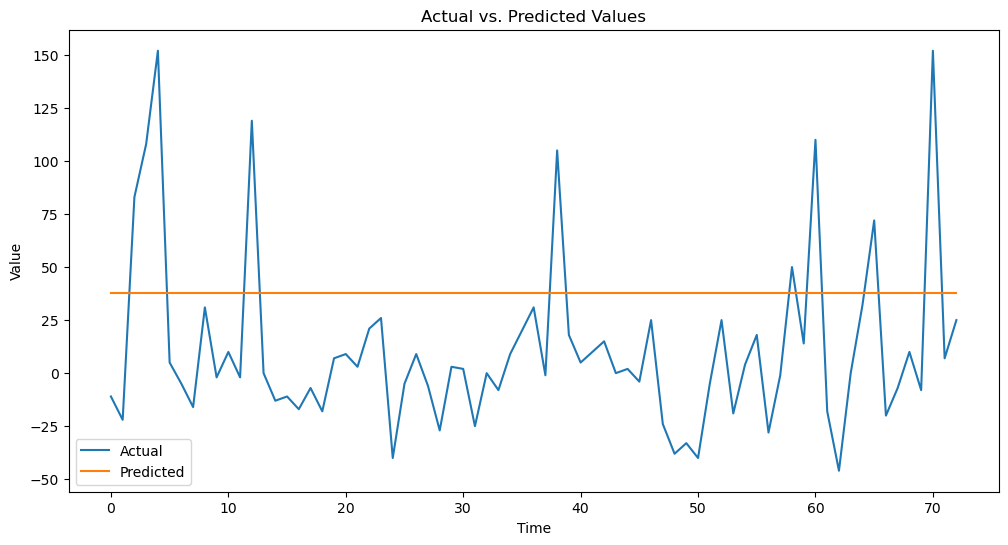

RMSE: 48.804
MAE: 43.285
MAPE: 932262337340043008.000%


In [89]:
P = pipline(data.loc[data['FLIGHT_ID'] == 'AA123'],True,True)
P.fit(1,1,10,10)
P.summary()
P.plot()
P.metrics()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -716.077
Date:                Wed, 08 May 2024   AIC                           1442.154
Time:                        16:15:30   BIC                           1460.538
Sample:                             0   HQIC                          1449.518
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.6768      0.991     11.785      0.000       9.735      13.619
ar.L1         -0.6012      0.104     -5.775      0.000      -0.805      -0.397
ar.L2          0.2122      0.063      3.367      0.0

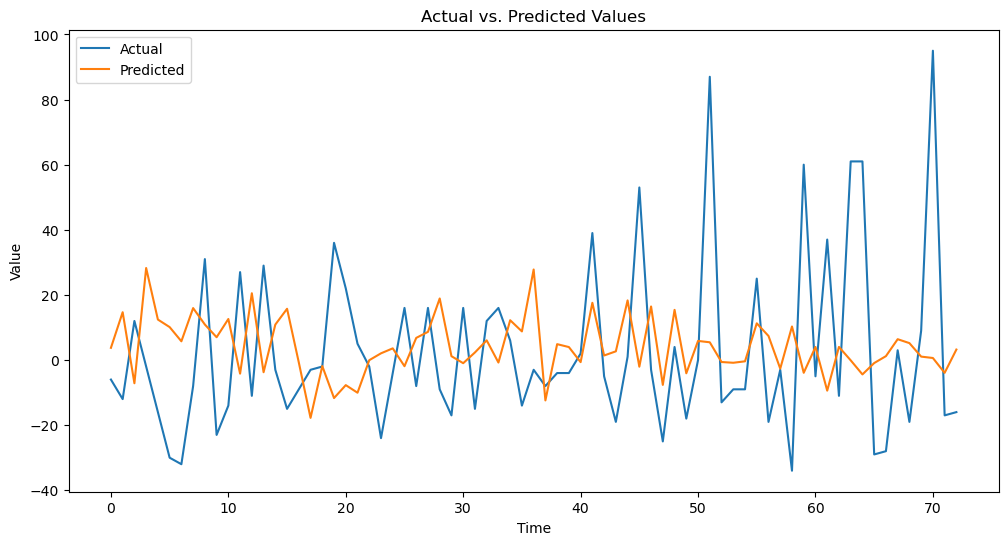

RMSE: 29.335
MAE: 22.967
MAPE: 36172052786900136.000%


In [90]:
P = pipline(data.loc[data['FLIGHT_ID'] == 'AA1406'],True,True)
P.fit(1,1,10,10)
P.summary()
P.plot()
P.metrics()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -617.871
Date:                Wed, 08 May 2024   AIC                           1241.742
Time:                        16:15:48   BIC                           1252.773
Sample:                             0   HQIC                          1246.161
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9711      0.400     14.932      0.000       5.187       6.755
ar.L1          0.1769      0.052      3.406      0.001       0.075       0.279
sigma2         4.0311      0.289     13.942      0.0

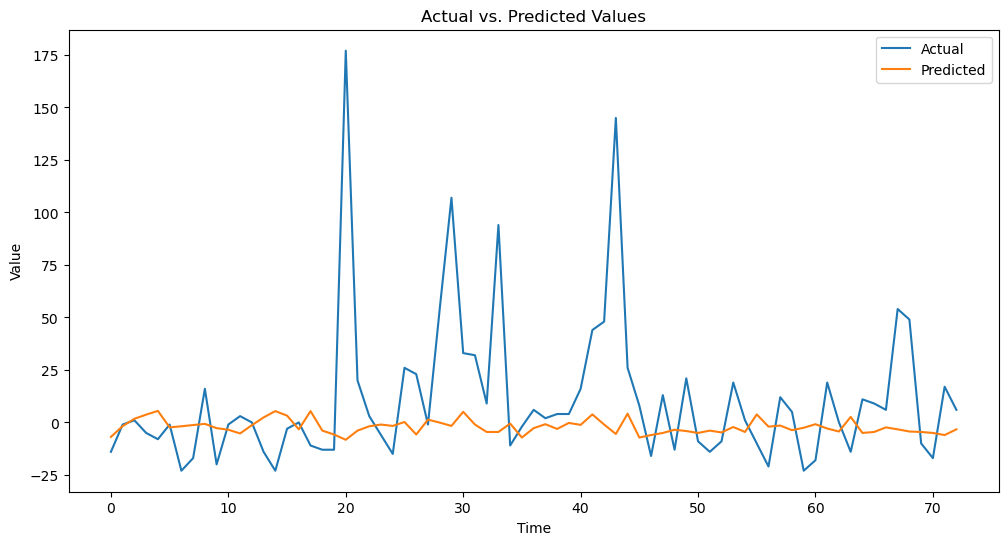

RMSE: 38.060
MAE: 21.932
MAPE: 55252821823427144.000%


In [91]:
P = pipline(data.loc[data['FLIGHT_ID'] == 'AA1486'],True,True)
P.fit(1,1,10,10)
P.summary()
P.plot()
P.metrics()